# Transcription Factor Project - Differential Expression Analysis and Minimum Distortion Embedding
**Robin Anwyl, UCSD Subramaniam Lab**

**Goal:** Analyze the hiPSC Perturb-seq dataset from the Mali lab (Nourreddine et al 2023 preprint) to investigate the effects of transcription factor knockouts (TF KDs)

**Guiding Questions:** What do TF KD effects reveal about:
* … the transcription regulatory network of hiPSCs, and TF crosstalk?
* … cell lineage?
* … how TFs influence chromatin remodeling?

# Import statements

In [1]:
# Using psp_env virtual environment
import sys
import os
repo_root = "/home/ranwyl/KOLF2.1J_Perturbation_Cell_Atlas/"
if repo_root not in sys.path:
    sys.path.insert(0, "/home/ranwyl/KOLF2.1J_Perturbation_Cell_Atlas/")

import psp
import gc
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'

# Differential expression analysis

We will carry out differential expression analysis at the gRNA level with PyDESeq2 using a pseudobulk method.

## Check for ~75% genome coverage and filter genes

In [14]:
data_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_Knockdown_Energy_Test_Filtered.h5ad"
adata = psp.utils.read_anndata(data_path)
adata

AnnData object with n_obs × n_vars = 101923 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [3]:
# Genome coverage testing
import numpy as np
import anndata as ad
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams.update({'font.size': 12})

def compute_genome_coverage_for_gRNA_pseudoreps(adata: ad.AnnData, gRNA: str, 
                                                rng: np.random.Generator,
                                                include_total: bool=True) -> dict:
    """
    Generate differential expression analysis pseudoreplicates for the given gRNA
    and compute genome coverage (number of genes expressed in rep divided by
    number of genes in dataset).
    """
    data_matrix = adata.X
    total_n_genes = adata.shape[1]
    genome_coverage = list() # n genes expressed in rep/n genes in adata
    # Create gRNA pseudoreplicates
    gRNA_indices = np.where(adata.obs['gRNA'] == gRNA)[0]
    n_cells = len(gRNA_indices)
    n_reps = 2 if n_cells <= 35 else 3
    rep_size = len(gRNA_indices) // n_reps
    sample_size = rep_size * n_reps
    sampled_gRNA_indices = rng.choice(gRNA_indices, sample_size, replace=False)
    # Number of expressed genes for all cells that received this gRNA
    gRNA_profile = data_matrix[sampled_gRNA_indices].sum(axis=0)
    gRNA_n_expr_genes = np.count_nonzero(gRNA_profile)
    # Compute genome coverage for each rep
    for rep in range(n_reps):
        # Number of expressed genes in rep
        start, stop = rep*rep_size, (rep+1)*rep_size
        rep_indices = sampled_gRNA_indices[start:stop]
        rep_profile = data_matrix[rep_indices].sum(axis=0)
        rep_n_expr_genes = np.count_nonzero(rep_profile)
        # Genome coverage
        rep_genome_coverage = np.round(rep_n_expr_genes / total_n_genes, 2)
        genome_coverage.append(rep_genome_coverage)
    # If no 3rd rep, add NaN value
    if len(genome_coverage) == 2:
        genome_coverage.append(np.nan)
    # Add total
    if include_total == True:
        total_genome_coverage = np.round(gRNA_n_expr_genes / total_n_genes, 2)
        genome_coverage.append(total_genome_coverage)
    # Return results
    return genome_coverage

def build_DE_gRNA_rep_genome_coverage_df(adata: ad.AnnData, n_cells_per_gRNA: list = [], 
                                    n_gRNA_per_size: int = 0, gRNA_list: list = [],
                                    random_state: int=42, include_total: bool=True,
                                    n_reps: int=3):
    """
    For each of the given numbers of cells per gRNA, sample a given number of gRNA,
    generate differential expression analysis pseudoreplicates for each gRNA,
    and compute genome coverage (number of genes expressed in rep divided by
    number of genes in dataset).
    """
    # Check that necessary inputs are provided
    if n_cells_per_gRNA != [] and n_gRNA_per_size == 0:
        print("Error: must provide number of gRNA to sample per size (cell number)")
    if n_cells_per_gRNA == [] and n_gRNA_per_size != 0:
        print("Error: must provide list of gRNA cell numbers")
    if n_cells_per_gRNA == [] and gRNA_list == []:
        print("Error: must provide list of gRNA or gRNA cell numbers")

    # Subset only KD cells and reset adata.X to counts
    adata = adata[adata.obs.perturbed == "True"].copy()
    adata.X = adata.layers["counts"].copy()

    # Build DF of number of cells per gRNA
    cells_per_gRNA = adata.obs.gRNA.value_counts()
    cells_per_gRNA = cells_per_gRNA.rename_axis("gRNA").reset_index(name="n_cells")

    # Generate RNG objects
    rng = np.random.default_rng(random_state)
    rngs = rng.spawn(2)
    gRNA_rng, reps_rng = rngs[0], rngs[1]
    
    # Initialize dict for genome coverage
    genome_coverage_dict = dict()

    # If a gRNA list is not provided, randomly sample gRNA
    if gRNA_list == []:
        # Loop through desired sizes of cells, e.g. [25, 30)
        for i in range(len(n_cells_per_gRNA)-1):
            # Filter to only gRNA with desired number of cells
            min_n_cells, max_n_cells = n_cells_per_gRNA[i], n_cells_per_gRNA[i+1]
            print(f"Sampling gRNA with {min_n_cells}-{max_n_cells-1} cells")
            filt_cells_per_gRNA = \
                cells_per_gRNA[(cells_per_gRNA["n_cells"] >= min_n_cells) & 
                (cells_per_gRNA["n_cells"] < max_n_cells)].copy()
            # If DF is empty, skip this cell number
            if filt_cells_per_gRNA.empty:
                continue
            # If number of gRNA > desired number, sample randomly
            if filt_cells_per_gRNA.shape[0] > n_gRNA_per_size:
                all_gRNA_indices = filt_cells_per_gRNA.index.tolist()
                chosen_gRNA_indices = gRNA_rng.choice(all_gRNA_indices, n_gRNA_per_size,
                                        replace=False)
                filt_cells_per_gRNA = \
                    filt_cells_per_gRNA[filt_cells_per_gRNA.index.isin(chosen_gRNA_indices)].copy()
            # Build gRNA list
            filt_cells_per_gRNA.sort_values(by="n_cells", inplace=True)
            gRNA_list += filt_cells_per_gRNA["gRNA"].tolist()
    else: # Sort gRNA list by number of cells per gRNA
        filt_cells_per_gRNA = cells_per_gRNA[cells_per_gRNA["gRNA"].isin(gRNA_list)].copy()
        filt_cells_per_gRNA.sort_values(by="n_cells", inplace=True)
        gRNA_list = filt_cells_per_gRNA["gRNA"].tolist()

    # For all gRNA, generate pseudoreps and calculate genome coverage
    for i in tqdm(range(len(gRNA_list)), desc="Computing genome coverage for gRNA"):
        gRNA = gRNA_list[i]
        # Get number of cells for gRNA
        gRNA_idx = cells_per_gRNA[cells_per_gRNA["gRNA"] == gRNA].index[0]
        gRNA_n_cells = cells_per_gRNA.at[gRNA_idx, "n_cells"]
        gRNA_entry = f"{gRNA} ({gRNA_n_cells} cells)"
        # Compute genome and gRNA gene coverage for pseudoreps
        genome_coverage_list = \
            compute_genome_coverage_for_gRNA_pseudoreps(adata, gRNA, reps_rng, include_total)
        genome_entry = {f"rep{i+1}": genome_coverage_list[i] for i in range(n_reps)}
        if include_total == True:
            genome_entry["total"] = genome_coverage_list[-1]
        genome_coverage_dict[gRNA_entry] = genome_entry
    
    # Build DFs
    genome_coverage_df = pd.DataFrame.from_dict(genome_coverage_dict, orient="index")
    return genome_coverage_df

def plot_gene_coverage_heatmap(genome_coverage_df: pd.DataFrame, title: str,
                               cmap: str="viridis", annot: bool=True,
                               figsize: tuple=(3,8)):
    plt.figure(figsize=figsize)
    nan_mask = genome_coverage_df.isna()
    ax = sns.heatmap(genome_coverage_df, cmap=cmap, annot=annot, annot_kws={"size": 8},
        mask=nan_mask, vmin=0, vmax=1, linewidths=0.5, xticklabels=True)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=10)
    plt.grid(False)
    plt.title(title, pad=10, fontsize=12)
    plt.show()

Sample 5 gRNA of each size [25, 30, 35, 40, 45, 50] cells. See if each pseudoreplicate achieves 75% genome coverage.

In [15]:
gRNA_genome_coverage_df = build_DE_gRNA_rep_genome_coverage_df(adata, 
    n_cells_per_gRNA = [25, 30, 35, 40, 45, 50], n_gRNA_per_size=5,
    include_total=False, random_state=12345)

Computing genome coverage for gRNA: 100%|██████████| 25/25 [00:43<00:00,  1.74s/it]


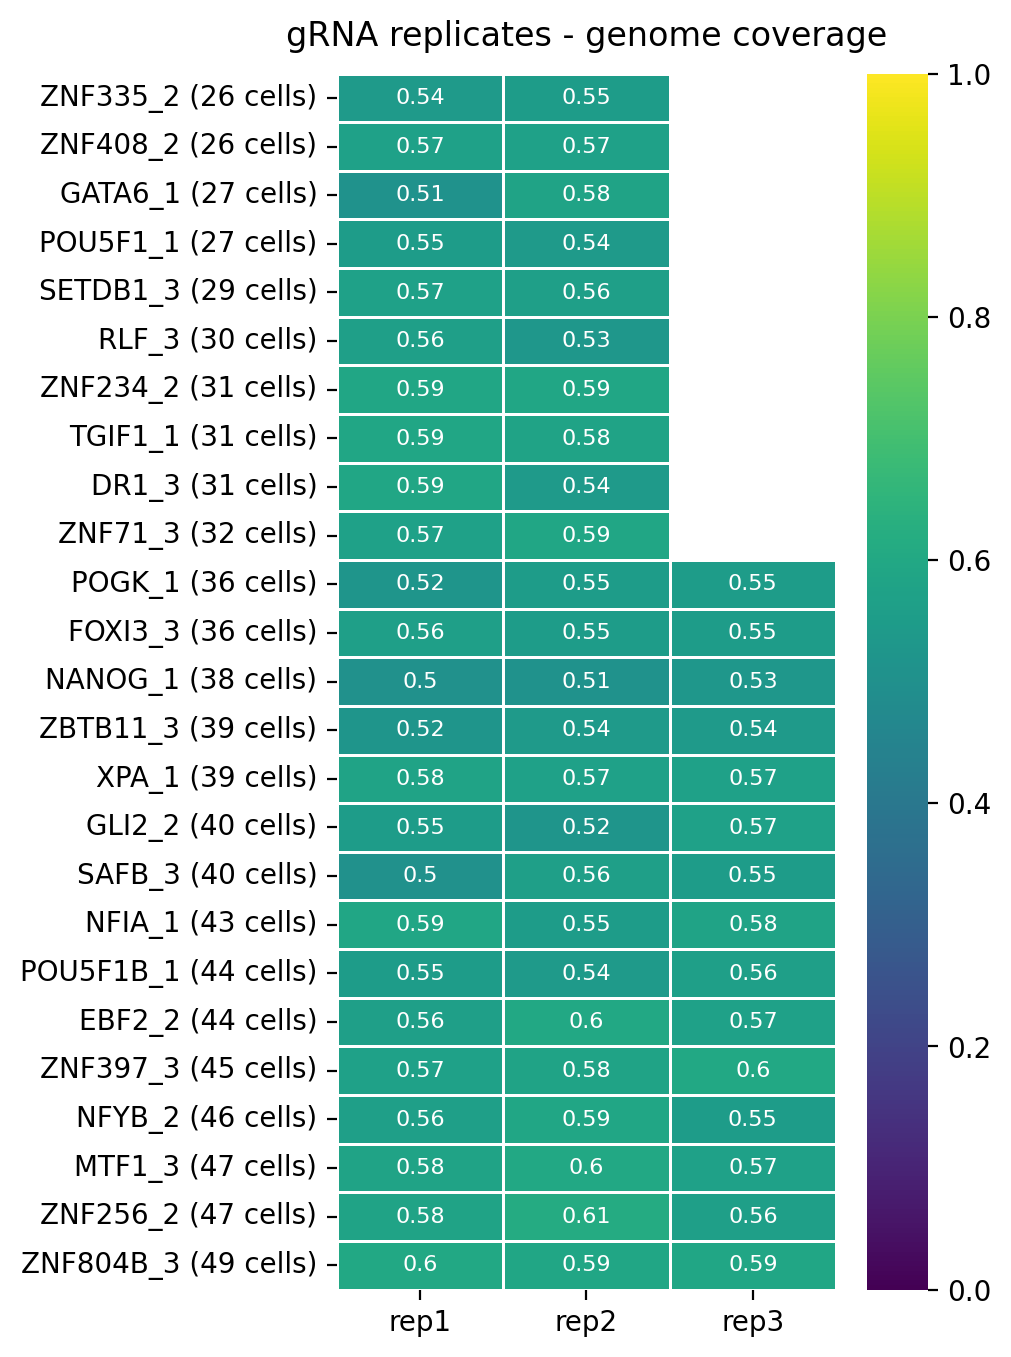

In [18]:
plot_gene_coverage_heatmap(gRNA_genome_coverage_df, figsize=(4,8),
    title="gRNA replicates - genome coverage")

Each pseudoreplicate only has 55-60% genome coverage. Apply stricter gene filter.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'
import seaborn as sns
import scanpy as sc

def filter_low_expressed_genes(adata, percent_threshold=0, min_n_cells=0, silent=False):
    """
    Filter out bottom percentile of genes with lowest expression (counts) 
    and genes expressed in fewer than min_n_cells cells.
    Do not filter out genes that are gene_targets in adata.
    """
    n_genes_before = adata.shape[1]

    # Filter genes expressed in fewer than min_n_cells cells
    if silent == False:
        print(f"Removing non-TF genes expressed in <{min_n_cells} cells")
    # Create data matrix
    if silent == False:
        print("Copying data")
    data_matrix = adata.layers["counts"] if "counts" in adata.layers else adata.X
    data_matrix = data_matrix.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        if silent == False:
            print("Converting data from sparse to dense")
        data_matrix = data_matrix.toarray()
    if silent == False:
        print("Filtering genes")
    # Create mask for TFs
    tf_mask = adata.var_names.isin(adata.obs.gene_target.unique().tolist())
    # Calculate number of cells expressing each gene
    gene_detected_counts = (data_matrix > 0).sum(axis=0)
    # Set cell number threshold and filter genes
    genes_pass_cell_thr = gene_detected_counts >= min_n_cells
    genes_to_keep = genes_pass_cell_thr | tf_mask
    adata = adata[:, genes_to_keep]
    print(f"Removed {n_genes_before - adata.n_vars} "
        f"non-TF genes expressed in <{min_n_cells} cells")
    n_genes_after_cell_filt = adata.n_vars
    del data_matrix

    # Filter bottom percentile of genes by expression (counts)
    if silent == False:
        print(f"\nRemoving bottom {percent_threshold}% of genes by expression (CPM)")
    if silent == False:
        print("Copying data")
    adata_norm = adata.copy()
    sc.pp.normalize_total(adata_norm, target_sum=1e6)
    if silent == False:
        print("Copying normalized data")
    data_matrix = adata_norm.X.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        if silent == False:
            print("Converting data from sparse to dense")
        data_matrix = data_matrix.toarray()
    if silent == False:
        print("Filtering genes")
    # Create mask for TFs
    tf_mask = adata.var_names.isin(adata.obs.gene_target.unique().tolist())
    # Calculate mean expression of each gene
    mean_expr_per_gene = data_matrix.mean(axis=0)
    # Set percent threshold and filter genes
    threshold = np.percentile(mean_expr_per_gene, percent_threshold)
    genes_pass_pct_thr = mean_expr_per_gene > threshold
    genes_to_keep = genes_pass_pct_thr | tf_mask
    adata = adata[:,genes_to_keep]
    print(f"Removed {n_genes_after_cell_filt - adata.n_vars} non-TF genes "
            f"with lowest {percent_threshold}% expression (CPM)")
    print(f"\nRemoved: {n_genes_before - adata.shape[1]} genes total")
    print(f"Remaining: {adata.n_vars} genes")
    del data_matrix
    del adata_norm
    gc.collect()
    return adata.copy()

In [16]:
adata_filt = filter_low_expressed_genes(adata, min_n_cells=100, percent_threshold=20)

Removing non-TF genes expressed in <100 cells
Copying data
Converting data from sparse to dense
Filtering genes
Removed 188 non-TF genes expressed in <100 cells

Removing bottom 20% of genes by expression (CPM)
Copying data
normalizing counts per cell
    finished (0:00:00)
Copying normalized data
Converting data from sparse to dense
Filtering genes
Removed 3740 non-TF genes with lowest 20% expression (CPM)

Removed: 3928 genes total
Remaining: 16115 genes


In [20]:
gRNA_genome_coverage_df_filt = build_DE_gRNA_rep_genome_coverage_df(adata_filt, 
    n_cells_per_gRNA = [25, 30, 35, 40, 45, 50], n_gRNA_per_size=5, 
    include_total=False, random_state=12345)

Computing genome coverage for gRNA: 100%|██████████| 25/25 [00:42<00:00,  1.72s/it]


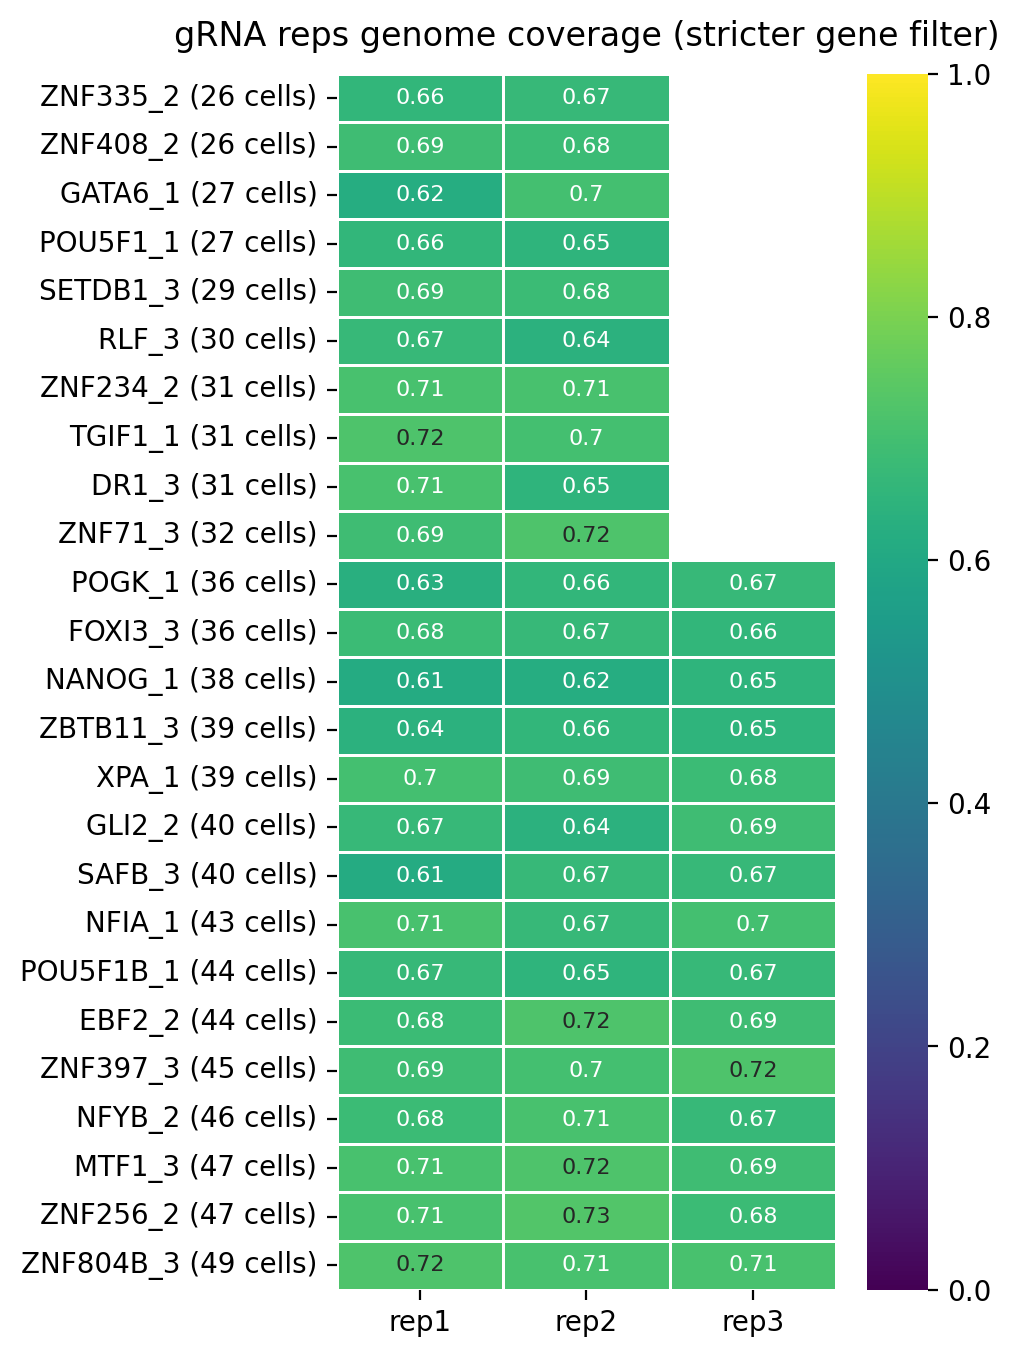

In [21]:
plot_gene_coverage_heatmap(gRNA_genome_coverage_df_filt, figsize=(4,8),
    title="gRNA reps genome coverage (stricter gene filter)")

Each pseudoreplicate now has ~65-75% genome coverage. This gene filter is adequate and now DE analysis can be performed.

In [ ]:
adata_filt.write("/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_KD_ETest_Gene_Filtered.h5ad")

## DE on gRNA - NTC benchmarking

In [2]:
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import warnings
from contextlib import contextmanager
import gc

def create_pseudobulk_dataset(adata: ad.AnnData, target_type: str = "gRNA",
                              ntc_benchmarking: bool = False,
                              min_counts_per_gene: int = 0,
                              layer: str = "counts",
                              min_cells_for_3_reps: int = 60,
                              approx_ntc_rep_size: int = 50,
                              random_state: int = 42,
                              ntc_target_delimiter: str = "NTC",
                              ntc_gRNA_delimiter: str = "Non-Targeting"):
    """
    Generate pseudobulk representation of adata with pseudoreplicates for 
    each gRNA or gene target (based on target_type).
    """
    # Error handling
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("Error: target_type must be 'gRNA' or 'gene_target'")
    if (ntc_benchmarking is True) & (target_type != "gRNA"):
        raise ValueError("Error: target_type must be 'gRNA' for NTC benchmarking")

    # Get targets
    targets = adata.obs[target_type].unique().tolist()
    # RNG objects for creating pseudoreplicates
    de_rng = np.random.default_rng(random_state)
    target_rngs = de_rng.spawn(len(targets))

    # Data structures for counts_df and metadata_df
    counts_arrays, counts_df_index = list(), list()
    metadata_condition, metadata_n_cells = list(), list()

    # Get data and convert from sparse to dense
    data_matrix = adata.layers[layer] if layer in adata.layers else adata.X
    if sparse.issparse(data_matrix):
        data_matrix = data_matrix.toarray()

    # Generate pseudoreplicates
    for target, rng in zip(targets, target_rngs):
        # Get target data
        target_indices = np.where(adata.obs[target_type] == target)[0]
        target_data = data_matrix[target_indices]
        
        # Calculate pseudoreplicate size
        n_target_cells = target_data.shape[0]
        if target_type == "gRNA": # gRNA targets
            if n_target_cells < min_cells_for_3_reps:
                rep1_size = n_target_cells // 2
                rep2_size = n_target_cells - rep1_size
                rep_sizes = [rep1_size, rep2_size]
            else:
                rep1_size = n_target_cells // 3
                rep2_size = (n_target_cells - rep1_size) // 2
                rep3_size = n_target_cells - rep1_size - rep2_size
                rep_sizes = [rep1_size, rep2_size, rep3_size]
        else: # Gene targets
            # Create NTC reps of about approx_ntc_rep_size as evenly as possible
            if target == ntc_target_delimiter:
                n_reps = round(n_target_cells / approx_ntc_rep_size)
                base_size = n_target_cells // n_reps
                remainder = n_target_cells % n_reps
                # First 'remainder' reps get one extra item
                rep_sizes = \
                    [base_size+1]*remainder + [base_size]*(n_reps-remainder)
            else:
                if n_target_cells < min_cells_for_3_reps:
                    rep1_size = n_target_cells // 2
                    rep2_size = n_target_cells - rep1_size
                    rep_sizes = [rep1_size, rep2_size]
                else:
                    rep1_size = n_target_cells // 3
                    rep2_size = (n_target_cells - rep1_size) // 2
                    rep3_size = n_target_cells - rep1_size - rep2_size
                    rep_sizes = [rep1_size, rep2_size, rep3_size]

        # Sample target indices for each rep
        target_cell_indices = np.arange(n_target_cells)
        rng.shuffle(target_cell_indices)
        rep_sizes_array = np.array(rep_sizes)
        rep_splits = np.cumsum(rep_sizes_array)[:-1]
        rep_indices = np.split(target_cell_indices, rep_splits)
        
        # Update pseudobulk counts
        n_reps = len(rep_sizes)
        target_counts = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
        for i in range(n_reps):
            target_counts[i] = \
                np.sum(target_data[rep_indices[i]], axis=0).astype(np.int64)
        counts_arrays.append(target_counts)
        target_hyphenated = target.replace("_", "-")
        rep_names = [f"{target_hyphenated}-rep{i+1}" for i in range(n_reps)]
        counts_df_index += rep_names
        
        # Update metadata
        metadata_n_cells += rep_sizes
        if ntc_gRNA_delimiter in target:
            metadata_condition += (["NTC"]*n_reps)
        else:
            metadata_condition += ([target_hyphenated]*n_reps)
            
    # Create counts DF
    counts_arr = np.concatenate(tuple(arr for arr in counts_arrays), axis=0)
    counts_df = pd.DataFrame(
        counts_arr,
        index=counts_df_index,
        columns=adata.var_names
    )
    # Filter lowly expressed genes
    gene_filter = counts_df.sum(axis=0) >= min_counts_per_gene
    counts_df = counts_df.loc[:, gene_filter]

    # Create metadata DF
    metadata_dict = {"sample": counts_df_index,
                    "condition": metadata_condition,
                    "n-cells-in-rep": metadata_n_cells}
    metadata_df = pd.DataFrame.from_dict(metadata_dict)
    metadata_df = metadata_df.set_index("sample").rename_axis(None)
    return counts_df, metadata_df

# Handle warnings (from PyDESeq2)
@contextmanager
def handle_warnings(suppress):
    if suppress:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            yield
    else:
        yield

def ntc_benchmarking_DE(adata: ad.AnnData,
                        layer: str = "counts",
                        min_cells_for_3_reps: int = 60,
                        random_state: int = 42,
                        ntc_target_delimiter: str = "NTC",
                        ntc_gRNA_delimiter: str = "Non-Targeting",
                        n_cpus: int = 20, alpha: float = 0.05,
                        suppress_warnings: bool = False):
    """
    Perform DE analysis on all NTC gRNA against all other NTC cells.
    Return dict {NTC gRNA: DE results DF for that NTC gRNA}.
    """
    adata = adata[adata.obs.gene_target == ntc_target_delimiter]
    # Create pseudobulk representation of dataset
    counts_df, metadata_df = \
        create_pseudobulk_dataset(adata, target_type="gRNA", 
                                  ntc_benchmarking=True, layer=layer,
                                  min_cells_for_3_reps=min_cells_for_3_reps,
                                  random_state=random_state,
                                  ntc_target_delimiter=ntc_target_delimiter,
                                  ntc_gRNA_delimiter=ntc_gRNA_delimiter)

    # Helper function to run DE on single NTC gRNA
    def ntc_benchmarking_single_gRNA(counts_df, metadata_df, target_ntc_gRNA):
        # Temporarily change 'condition' to 'perturbed'
        metadata_df = metadata_df.copy()
        metadata_df.loc[
            metadata_df.index.str.contains(target_ntc_gRNA), "condition"] = "perturbed"
        # Run DESeq2
        with handle_warnings(suppress_warnings):
            dds_inference = DefaultInference(n_cpus=1)
            ds_inference = DefaultInference(n_cpus=1)
            dds = DeseqDataSet(counts=counts_df, 
                               metadata=metadata_df,
                               design_factors="condition",
                               continuous_factors=["n-cells-in-rep"],
                               ref_level=["condition", "NTC"],
                               inference=dds_inference, 
                               quiet=True)
            dds.deseq2()
            ds = DeseqStats(dds, 
                            contrast=["condition", "perturbed", "NTC"], 
                            alpha=alpha,
                            inference=ds_inference, 
                            quiet=True)
            ds.summary()
            return ds.results_df
    
    # Run DE on all NTC gRNA
    targets = adata.obs.gRNA.unique().tolist()
    targets_hyphenated = [target.replace("_", "-") for target in targets]
    with tqdm_joblib(desc="Running DE analysis", total=len(targets)):
        de_results = Parallel(n_jobs=n_cpus)(
            delayed(ntc_benchmarking_single_gRNA)(counts_df, metadata_df, target)
                    for target in targets_hyphenated)
    de_results_dict = {targets[i]: de_results[i] for i in range(len(targets))}
    return de_results_dict

def report_ntc_benchmarking_results(results_dict: dict, alpha: float = 0.05):
        """
        Determine the threshold (number of DEGs) at which 95% of NTC gRNA have 
        fewer DEGs. Plot the distribution of DEGs for NTC gRNA and print
        a summary of results.
        """
        # Counts DEGs per gRNA
        deg_counts = {}
        for ntc_gRNA, result_df in results_dict.items():
            if result_df is None:
                continue
            deg_count = sum((result_df['padj'] < alpha) & pd.notna(result_df['padj']))
            deg_counts[ntc_gRNA] = deg_count

        # Create results DataFrame
        benchmark_results = pd.DataFrame.from_dict(deg_counts, orient='index', columns=['n_DEGs'])
        benchmark_results = benchmark_results.sort_values('n_DEGs', ascending=False)
        
        # Calculate 95th percentile threshold (FDR 0.05)
        if len(benchmark_results) > 0:
            deg_threshold = np.percentile(benchmark_results['n_DEGs'].values, 95)
        else:
            print("No results to calculate percentile.")
            return
        
        # Plot results with improved styling - code from psp.de.benchmark_NTC_FDR()
        # Set style parameters
        plt.rcParams['axes.spines.top'] = False
        plt.rcParams['axes.spines.right'] = False
        # Create figure
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        fig.patch.set_facecolor('white')
        # Prepare bar plot data: discrete DEG counts
        deg_counts = benchmark_results['n_DEGs'].value_counts().sort_index()
        # Create bar plot
        ax.bar(
            deg_counts.index,
            deg_counts.values,
            alpha=0.8,
            color='#4682B4',   # Steel blue
            edgecolor='white',
            linewidth=1.5
        )
        # Add threshold line with improved styling
        ax.axvline(
            deg_threshold,
            color='#B22222',  # Firebrick
            linestyle='-',
            linewidth=2,
            alpha=0.8
        )
        # Labels and title with improved styling
        ax.set_xlabel('Number of DEGs', fontsize=12, labelpad=10)
        ax.set_ylabel('Number of NTC sgRNA comparisons', fontsize=12, labelpad=10)
        ax.set_title(f'Distribution of DEGs in NTC comparisons', fontsize=14, pad=20)
        # Turn off grid
        ax.grid(False)
        # Adjust tick parameters
        ax.tick_params(axis='both', which='major', labelsize=10, pad=5)
        # Add some padding to the axes
        ax.margins(x=0.02)
        # Add custom legend-like text at bottom
        threshold_text = f"FDR 0.05 threshold: {int(deg_threshold)} DEGs"
        fig.text(0.5, 0.01, threshold_text, ha='center', fontsize=11, color='#B22222', weight='bold')
        # Adjust layout
        plt.tight_layout(rect=[0, 0.02, 1, 0.98])
        plt.show()
        
        # Print statistics
        print(f"NTC Benchmark Statistics:")
        print(f"  • FDR 0.05 threshold: {int(deg_threshold)} DEGs")
        print(f"  • NTC comparisons analyzed: {len(benchmark_results)}")
        print(f"  • Mean DEGs per comparison: {benchmark_results['n_DEGs'].mean():.1f}")
        print(f"  • Median DEGs per comparison: {benchmark_results['n_DEGs'].median():.1f}")
        print(f"  • 95% of comparisons have < {int(deg_threshold)} DEGs")

        return int(deg_threshold), benchmark_results

In [3]:
filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_KD_ETest_Gene_Filtered.h5ad"
adata = psp.utils.read_anndata(filepath)
adata

AnnData object with n_obs × n_vars = 101923 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [8]:
print(f"Number of NTC gRNAs: {len(adata[adata.obs.perturbed == 'False'].obs.gRNA.unique())}")

Number of NTC gRNAs: 234


In [4]:
ntc_benchmark_results = ntc_benchmarking_DE(adata, n_cpus=50, suppress_warnings=True)

Running DE analysis:   0%|          | 0/234 [00:00<?, ?it/s]

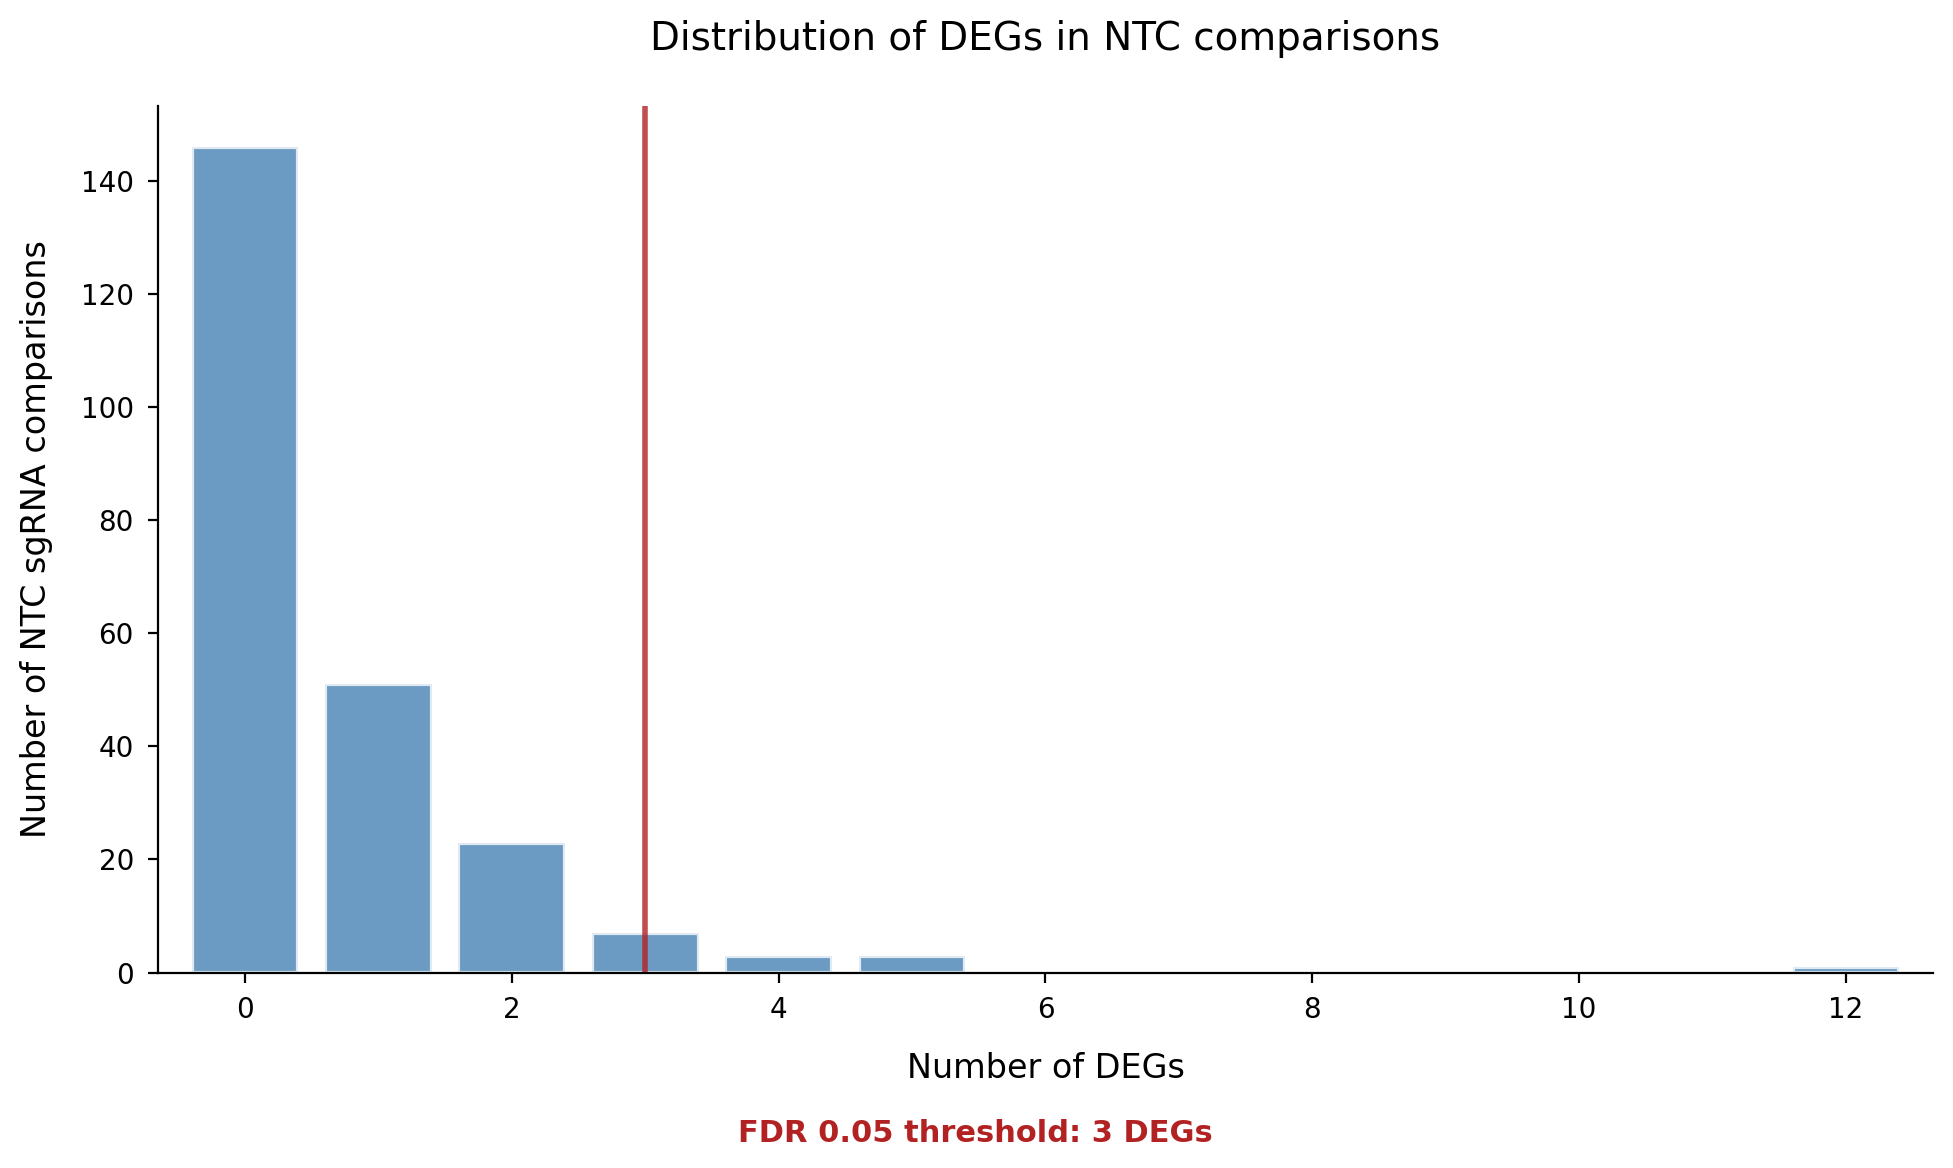

NTC Benchmark Statistics:
  • FDR 0.05 threshold: 3 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 0.7
  • Median DEGs per comparison: 0.0
  • 95% of comparisons have < 3 DEGs


In [5]:
ntc_deg_threshold, ntc_benchmark_df = \
    report_ntc_benchmarking_results(ntc_benchmark_results)

In [6]:
ntc_benchmark_df[ntc_benchmark_df["n_DEGs"] > 3]

,n_DEGs
Non-Targeting_398,12
Non-Targeting_226,5
Non-Targeting_506,5
Non-Targeting_844,5
Non-Targeting_351,4
Non-Targeting_482,4
Non-Targeting_418,4


In [9]:
def ntc_threshold_filtering(adata, deg_threshold, benchmark_df):
    gRNA_to_remove = \
        benchmark_df[benchmark_df["n_DEGs"] > deg_threshold].index.tolist()
    adata_filtered = adata[~(adata.obs.gRNA.isin(gRNA_to_remove))].copy()
    return adata_filtered

In [10]:
adata_benchmarked = ntc_threshold_filtering(adata, ntc_deg_threshold, ntc_benchmark_df)
adata_benchmarked

AnnData object with n_obs × n_vars = 101538 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [11]:
print(f"Number of NTC gRNAs after filtering: "
      f"{len(adata_benchmarked[adata_benchmarked.obs.perturbed == 'False'].obs.gRNA.unique())}")

Number of NTC gRNAs after filtering: 227


In [ ]:
save_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked.h5ad"
adata_benchmarked.write(save_path)

## DE on gene targets

DE analysis at gene target level

In [3]:
# run_pydeseq2() and handle_warnings
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import warnings
from contextlib import contextmanager
import gc

# Handle warnings from PyDESeq2
@contextmanager
def handle_warnings(suppress):
    if suppress:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            yield
    else:
        yield

def run_pydeseq2(counts_df: pd.DataFrame, metadata_df: pd.DataFrame,
                 targets: list, n_cpus: int = 20, 
                 alpha: float = 0.05, quiet: bool = False,
                 return_dds_object = False, suppress_warnings: bool = False,
                 shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True):
    """
    Perform DE analysis with PyDESeq2 on perturbing gRNA or gene targets.
    Uses parallel processing for DeseqStats.summary().
    """
    # Get targets (PyDESeq2 0.4.12 can't handle underscores)
    targets_hyphenated = [t.replace("_", "-") for t in targets]
    # Run DE analysis
    with handle_warnings(suppress_warnings):
        # Set number of CPUs to use
        dds_inference = DefaultInference(n_cpus=n_cpus)
        ds_inference = DefaultInference(n_cpus=1)
        # Fit dispersions and LFCs
        dds_quiet = True if quiet else False
        dds = DeseqDataSet(counts=counts_df, metadata=metadata_df,
                          design_factors="condition",
                          continuous_factors=["n-cells-in-rep"],
                          ref_level=["condition", "NTC"],
                          inference=dds_inference, quiet=dds_quiet
                          )
        print(f"Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()")
        dds.deseq2()
        # Helper function for statistical testing
        def run_DeseqStats(target, shrink_lfcs, lfc_shrink_adapt):
            contrast=["condition", target, "NTC"]
            ds = DeseqStats(dds, contrast=contrast, alpha=alpha,
                            inference=ds_inference, quiet=True)
            ds.summary()
            if shrink_lfcs:
                coeff = f"{contrast[0]}_{contrast[1]}_vs_{contrast[2]}"
                ds.lfc_shrink(coeff=coeff, adapt=lfc_shrink_adapt)
            return ds.results_df
        # Perform statistical testing in parallel
        with tqdm_joblib(desc="Running DE statistical testing", total=len(targets_hyphenated)):
            ds_results = Parallel(n_jobs=n_cpus)(
                delayed(run_DeseqStats)(target, shrink_lfcs, lfc_shrink_adapt)
                        for target in targets_hyphenated)
        # Return results
        de_results_dict = {targets[i]: ds_results[i] for i in range(len(targets))}
        if return_dds_object:
            return de_results_dict, dds
        else:
            return de_results_dict

In [4]:
# create_gene_target_pseudobulk_dataset()

import math

def create_gene_target_pseudobulk_dataset(adata: ad.AnnData,
                                        layer: str = "counts",
                                        min_cells_for_3_reps: int = 60,
                                        max_cells_per_rep: int = 100,
                                        ntc_gRNA_as_reps: bool = True,
                                        approx_ntc_rep_size: int = 50,
                                        random_state: int = 42,
                                        gene_target_obs_col: str = "gene_target",
                                        ntc_target_delimiter: str = "NTC"
                                        ):
    """
    Generate pseudobulk representation of adata with pseudoreplicates for each
    gene target. Default perturbation rep size: use 2 reps for a gene target 
    if <60 cells, 3 reps if 60-300 cells, and >3 reps of max 100 cells if >300 cells.
    If ntc_gRNA_as_reps is True, use each NTC gRNA as a NTC replicate. 
    If ntc_gRNA_as_reps is False, create NTC pseudoreps of ~approx_ntc_rep_size.
    """
    # Data structures for counts_df and metadata_df
    counts_arrays, counts_df_index = list(), list()
    metadata_condition, metadata_n_cells = list(), list()

    # Get data and convert from sparse to dense
    data_matrix = adata.layers[layer] if layer in adata.layers else adata.X
    if sparse.issparse(data_matrix):
        data_matrix = data_matrix.toarray()

    # Get gene targets
    targets = adata.obs[gene_target_obs_col].unique().tolist()
    if ntc_gRNA_as_reps:
        targets.remove(ntc_target_delimiter)

    # RNG objects for creating pseudoreplicates
    de_rng = np.random.default_rng(random_state)
    target_rngs = de_rng.spawn(len(targets))

    # Generate pseudoreplicates
    for target, rng in zip(targets, target_rngs):
        # Get target data
        target_indices = np.where(adata.obs[gene_target_obs_col] == target)[0]
        target_data = data_matrix[target_indices]
        
        # Calculate pseudoreplicate size
        n_target_cells = target_data.shape[0]
        if target == ntc_target_delimiter:
            if ntc_gRNA_as_reps:
                continue
            # Create NTC reps of ~approx_ntc_rep_size as evenly as possible
            else:
                n_reps = round(n_target_cells / approx_ntc_rep_size)
                base_size = n_target_cells // n_reps
                remainder = n_target_cells % n_reps
                # First 'remainder' reps get one extra item
                rep_sizes = \
                    [base_size+1]*remainder + [base_size]*(n_reps-remainder)
        # Create perturbation reps
        else:
            if n_target_cells < min_cells_for_3_reps: # 2 reps
                rep1_size = n_target_cells // 2
                rep2_size = n_target_cells - rep1_size
                rep_sizes = [rep1_size, rep2_size]
            elif (n_target_cells >= min_cells_for_3_reps) & \
                    (n_target_cells <= 3*max_cells_per_rep): # 3 reps
                rep1_size = n_target_cells // 3
                rep2_size = (n_target_cells - rep1_size) // 2
                rep3_size = n_target_cells - rep1_size - rep2_size
                rep_sizes = [rep1_size, rep2_size, rep3_size]
            else: # >3 reps
                n_reps = math.ceil(n_target_cells / max_cells_per_rep)
                base_size = n_target_cells // n_reps
                remainder = n_target_cells % n_reps
                # First 'remainder' reps get one extra item
                rep_sizes = \
                    [base_size+1]*remainder + [base_size]*(n_reps-remainder)

        # Sample target indices for each rep
        target_cell_indices = np.arange(n_target_cells)
        rng.shuffle(target_cell_indices)
        rep_sizes_array = np.array(rep_sizes)
        rep_splits = np.cumsum(rep_sizes_array)[:-1]
        rep_indices = np.split(target_cell_indices, rep_splits)
        
        # Update pseudobulk counts
        n_reps = len(rep_sizes)
        target_counts = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
        for i in range(n_reps):
            target_counts[i] = \
                np.sum(target_data[rep_indices[i]], axis=0).astype(np.int64)
        counts_arrays.append(target_counts)
        target_hyphenated = target.replace("_", "-")
        rep_names = [f"{target_hyphenated}-rep{i+1}" for i in range(n_reps)]
        counts_df_index += rep_names
        
        # Update metadata
        metadata_n_cells += rep_sizes
        metadata_condition += ([target_hyphenated]*n_reps)
            
    # If using NTC gRNAs as reps
    if ntc_gRNA_as_reps:
        ntc_gRNAs = adata[adata.obs.perturbed == "False"].obs.gRNA.unique().tolist()
        for ntc_gRNA in ntc_gRNAs:
            target_indices = np.where(adata.obs.gRNA == ntc_gRNA)[0]
            target_data = data_matrix[target_indices]
            target_counts = np.sum(target_data, axis=0).astype(np.int64)
            # Update counts
            counts_arrays.append(target_counts.reshape(1, -1))
            counts_df_index.append(ntc_gRNA.replace("_", "-"))
            # Update metadata
            metadata_n_cells.append(target_data.shape[0])
            metadata_condition.append("NTC")

    # Create counts DF
    counts_arr = np.concatenate(tuple(arr for arr in counts_arrays), axis=0)
    counts_df = pd.DataFrame(
        counts_arr,
        index=counts_df_index,
        columns=adata.var_names
    )

    # Create metadata DF
    metadata_dict = {"sample": counts_df_index,
                    "condition": metadata_condition,
                    "n-cells-in-rep": metadata_n_cells}
    metadata_df = pd.DataFrame.from_dict(metadata_dict)
    metadata_df = metadata_df.set_index("sample").rename_axis(None)
    return counts_df, metadata_df

In [5]:
def create_gene_target_DE_chunks(counts_df: pd.DataFrame, 
                                 metadata_df: pd.DataFrame,
                                 max_chunk_size: int = 1100, 
                                 n_chunks=None,
                                 min_cells_for_3_reps: int = 60,
                                 max_cells_per_rep: int = 100,
                                 random_state: int = 42,
                                 gene_target_obs_col: str = "gene_target"):
    """
    Divide gene target DE pseudobulk dataset into chunks that each contain all 
    NTC replicates and a subset of perturbations.
    """
    # Get number of chunks
    n_target_samples = len(metadata_df[metadata_df["condition"] != "NTC"])
    n_ntc_samples = len(metadata_df[metadata_df["condition"] == "NTC"])
    if n_chunks is None:
        n_chunks = round(n_target_samples / (max_chunk_size - n_ntc_samples))
    print(f"{n_target_samples} perturbation samples, {n_ntc_samples} NTC samples, "
        f"{n_chunks} chunks")

    # Get number of perturbations per chunk
    target_counts_df = \
        pd.DataFrame(adata[adata.obs.perturbed == "True"].obs[gene_target_obs_col].value_counts())
    two_reps_mask = target_counts_df["count"] < min_cells_for_3_reps
    three_reps_mask = (target_counts_df["count"] >= min_cells_for_3_reps) & \
                        (target_counts_df["count"] <= 3*max_cells_per_rep)
    four_or_more_reps_mask = target_counts_df["count"] > 3*max_cells_per_rep
    n_rep_sizes = 3
    n_targets_per_rep_size = \
        [len(target_counts_df[two_reps_mask]), 
         len(target_counts_df[three_reps_mask]),
         len(target_counts_df[four_or_more_reps_mask])] # n targets for each rep size
    print(f"{n_targets_per_rep_size[0]} targets with 2 reps, "
          f"{n_targets_per_rep_size[1]} targets with 3 reps, "
          f"{n_targets_per_rep_size[2]} targets with 4+ reps")
    n_chunk_targets_per_rep_size = np.zeros((n_rep_sizes, n_chunks), dtype=int)
    for i in range(n_rep_sizes):
        n_targets = n_targets_per_rep_size[i]
        base_size = n_targets // n_chunks
        remainder = n_targets % n_chunks
        n_targets_per_chunk = [base_size+1]*remainder + [base_size]*(n_chunks-remainder)
        n_chunk_targets_per_rep_size[i] = np.array(n_targets_per_chunk)
    print(f"Number of targets with 2 reps per chunk: {n_chunk_targets_per_rep_size[0]}")
    print(f"Number of targets with 3 reps per chunk: {n_chunk_targets_per_rep_size[1]}")
    print(f"Number of targets with 4+ reps per chunk: {n_chunk_targets_per_rep_size[2]}")
    print(f"Total number of targets per chunk: {n_chunk_targets_per_rep_size.sum(axis=0)}")

    # Determine perturbations per chunk
    rng = np.random.default_rng(random_state)
    targets_per_rep_size = [target_counts_df[two_reps_mask].index.tolist(),
                            target_counts_df[three_reps_mask].index.tolist(),
                            target_counts_df[four_or_more_reps_mask].index.tolist()]
    chunk_indices_per_rep_size = list() # array of size 3 x n_chunks
    for i in range(n_rep_sizes):
        n_targets_per_chunk = n_chunk_targets_per_rep_size[i] # vector of size n_chunks
        target_indices = np.arange(n_targets_per_rep_size[i]) # vector of size n_targets_per_chunk
        rng.shuffle(target_indices)
        chunk_splits = np.cumsum(n_targets_per_chunk)[:-1]
        chunk_indices = np.split(target_indices, chunk_splits)
        chunk_indices_per_rep_size.append(chunk_indices)

    # Divide pseudobulk dataset into chunks
    chunk_counts_dfs, chunk_meta_dfs = list(), list()
    all_chunk_targets = list() # array of size n_chunks x n_targets_per_chunk
    for i in range(n_chunks): # Loop through chunks
        chunk_targets = list()
        # Add 2-rep targets, 3-rep targets, and 4-or-more-rep targets to chunk target list
        for j in range(n_rep_sizes): # Loop through rep sizes
            rep_size_chunk_indices = chunk_indices_per_rep_size[j]
            rep_size_targets = targets_per_rep_size[j]
            rep_chunk_targets = [rep_size_targets[k] for k in rep_size_chunk_indices[i]]
            chunk_targets += rep_chunk_targets
        # Create counts and metadata DFs
        chunk_targets_hyphenated = [t.replace("_", "-") for t in chunk_targets]
        chunk_meta_df = \
            metadata_df.loc[(metadata_df["condition"].isin(chunk_targets_hyphenated))
                            | (metadata_df["condition"] == "NTC")]
        chunk_samples = chunk_meta_df.index.tolist()
        chunk_counts_df = counts_df.loc[counts_df.index.isin(chunk_samples)]
        chunk_counts_dfs.append(chunk_counts_df)
        chunk_meta_dfs.append(chunk_meta_df)
        all_chunk_targets.append(chunk_targets)
    
    # Print and return results
    samples_per_chunk = np.array([len(df) for df in chunk_counts_dfs])
    ntc_samples_per_chunk = np.array([n_ntc_samples] * n_chunks)
    print(f"Total samples per chunk: {samples_per_chunk}")
    print(f"Perturbed samples per chunk: {samples_per_chunk - ntc_samples_per_chunk}")
    return chunk_counts_dfs, chunk_meta_dfs, all_chunk_targets

In [ ]:
def run_gene_target_dataset_DE(
        adata: ad.AnnData,
        max_chunk_size: int = 1100, n_chunks=None,
        layer: str = "counts",
        min_cells_for_3_reps: int = 60,
        max_cells_per_rep: int = 100,
        ntc_gRNA_as_reps: bool = True,
        approx_ntc_rep_size: int = 50,
        random_state: int = 42,
        ntc_target_delimiter: str = "NTC",
        gene_target_obs_col: str = "gene_target",
        n_cpus: int = 20, alpha: float = 0.05,
        return_dds_objects: bool = False, quiet: bool = False,
        shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True,
        suppress_warnings: bool = False, debug: bool = False,
        counts_df=None, metadata_df=None):
    """
    Run pseudobulk DE on perturbing gRNA or gene targets (based on target_type).
    Create pseudobulk dataset and break into chunks that each include all NTC reps
    and a subset of perturbing gRNAs/gene targets. Run DE on each chunk.
    """
    # Create pseudobulk dataset
    if (counts_df is None) or (metadata_df is None):
        print("Generating pseudobulk representation of dataset")
        counts_df, metadata_df = \
            create_gene_target_pseudobulk_dataset(
                adata, layer=layer,
                ntc_gRNA_as_reps=ntc_gRNA_as_reps,
                approx_ntc_rep_size = approx_ntc_rep_size,
                min_cells_for_3_reps=min_cells_for_3_reps,
                max_cells_per_rep=max_cells_per_rep, 
                random_state=random_state,
                ntc_target_delimiter=ntc_target_delimiter,
                gene_target_obs_col=gene_target_obs_col
                )
    
    # Create DE chunk pseudobulk datasets
    print(f"Creating chunk pseudobulk datasets")
    chunk_counts_dfs, chunk_meta_dfs, all_chunk_targets = \
        create_gene_target_DE_chunks(
            counts_df, metadata_df,
            max_chunk_size=max_chunk_size,
            n_chunks=n_chunks,
            min_cells_for_3_reps=min_cells_for_3_reps,
            max_cells_per_rep=max_cells_per_rep,
            random_state=random_state,
            gene_target_obs_col=gene_target_obs_col)
    
    # Run DE analysis on each chunk pseudobulk dataset
    de_results_dict = dict()
    n_chunks_to_run = 1 if debug else n_chunks
    if return_dds_objects:
        dds_objects = list()
    for i in range(n_chunks_to_run):
        print(f"\nRunning DE analysis on chunk {i+1} of {n_chunks}")
        chunk_results = \
            run_pydeseq2(chunk_counts_dfs[i], 
                         chunk_meta_dfs[i],
                         targets=all_chunk_targets[i],
                         n_cpus=n_cpus, alpha=alpha, quiet=quiet,
                         return_dds_object=return_dds_objects,
                         shrink_lfcs=shrink_lfcs,
                         lfc_shrink_adapt=lfc_shrink_adapt,
                         suppress_warnings=suppress_warnings)
        if return_dds_objects:
            de_results_dict.update(chunk_results[0])
            dds_objects.append(chunk_results[1])
        else:
            de_results_dict.update(chunk_results)
    if return_dds_objects:
        return de_results_dict, dds_objects
    else:
        return de_results_dict

In [7]:
def build_DE_df(results_dict):
    df_list = list()
    for target, df in results_dict.items():
        df = df.sort_index() # Sort genes alphabetically
        # Prepend perturbation name to each column label
        new_col_names = {col: f"{target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

In [9]:
file_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked.h5ad"
adata = psp.utils.read_anndata(file_path)
adata

AnnData object with n_obs × n_vars = 101538 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [ ]:
counts_gene_targets, meta_gene_targets = \
    create_gene_target_pseudobulk_dataset(adata,
                                          ntc_gRNA_as_reps=True,
                                          min_cells_for_3_reps=60,
                                          max_cells_per_rep=100,
                                          random_state=42)

In [ ]:
de_results_gene_targets, dds_objects_gene_targets = \
    run_gene_target_dataset_DE(adata, 
                                counts_df=counts_gene_targets,
                                metadata_df=meta_gene_targets,
                                n_chunks=3, n_cpus=75,
                                ntc_gRNA_as_reps=True,
                                min_cells_for_3_reps=60,
                                max_cells_per_rep=100,
                                random_state=42,
                                return_dds_objects=True)

Creating chunk pseudobulk datasets
2112 perturbation samples, 227 NTC samples, 3 chunks
91 targets with 2 reps, 618 targets with 3 reps, 17 targets with 4+ reps
Number of targets with 2 reps per chunk: [31 30 30]
Number of targets with 3 reps per chunk: [206 206 206]
Number of targets with 4+ reps per chunk: [6 6 5]
Total number of targets per chunk: [243 242 241]
Total samples per chunk: [933 932 928]
Perturbed samples per chunk: [706 705 701]
Running DE analysis on chunk 1 of 3

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.33 seconds.

Fitting dispersions...
... done in 361.46 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.27 seconds.

Fitting MAP dispersions...
... done in 41.17 seconds.

Fitting LFCs...
... done in 33.70 seconds.

Calculating cook's distance...
... done in 0.83 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/243 [00:00<?, ?it/s]

Running DE analysis on chunk 2 of 3

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.35 seconds.

Fitting dispersions...
... done in 384.76 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.27 seconds.

Fitting MAP dispersions...
... done in 39.85 seconds.

Fitting LFCs...
... done in 34.58 seconds.

Calculating cook's distance...
... done in 0.79 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/242 [00:00<?, ?it/s]

Running DE analysis on chunk 3 of 3

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.35 seconds.

Fitting dispersions...
... done in 421.84 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 37.67 seconds.

Fitting LFCs...
... done in 35.51 seconds.

Calculating cook's distance...
... done in 0.85 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/241 [00:00<?, ?it/s]

In [ ]:
de_results_df_gene_targets = build_DE_df(de_results_gene_targets)
de_results_df_gene_targets.head()

,TFAP2E_baseMean,TFAP2E_log2FoldChange,TFAP2E_lfcSE,TFAP2E_stat,TFAP2E_pvalue,TFAP2E_padj,ZKSCAN7_baseMean,ZKSCAN7_log2FoldChange,ZKSCAN7_lfcSE,ZKSCAN7_stat,...,SIX6_lfcSE,SIX6_stat,SIX6_pvalue,SIX6_padj,ESRRG_baseMean,ESRRG_log2FoldChange,ESRRG_lfcSE,ESRRG_stat,ESRRG_pvalue,ESRRG_padj
A1BG,4.288014,0.215774,0.603310,0.357650,0.720605,0.999818,4.288014,0.092251,0.603846,0.152772,...,0.305996,-2.346219,0.018965,0.815784,4.136067,-0.300046,0.253307,-1.184514,0.236210,0.921599
A1BG-AS1,0.654281,0.125053,1.466596,0.085267,0.932049,0.999818,0.654281,-0.001957,1.468084,-0.001333,...,0.633151,0.259516,0.795237,0.999988,0.638291,0.851325,0.467333,1.821665,0.068506,0.828367
A2M,0.563516,0.771556,1.476445,0.522576,0.601269,0.999818,0.563516,-0.794152,2.399144,-0.331015,...,0.657282,0.555595,0.578488,0.987858,0.579372,0.253867,0.631455,0.402036,0.687658,0.990020
A2ML1,2.080172,0.228122,1.044360,0.218432,0.827092,0.999818,2.080172,1.430906,0.684694,2.089846,...,0.365398,-0.716801,0.473497,0.986759,2.048557,-0.418370,0.374944,-1.115822,0.264498,0.923641
A2ML1-AS1,5.946591,0.477421,0.501640,0.951722,0.341238,0.999818,5.946591,-0.004348,0.563476,-0.007717,...,0.210733,0.245300,0.806224,0.999988,5.675613,-0.065157,0.205259,-0.317440,0.750910,0.997073


In [ ]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_gene_targets_3chunks_ntc_gRNA_reps.pkl"
de_results_df_gene_targets.to_pickle(filepath_pkl)

## Rename Ensembl ID genes in DE results

Rename genes that are listed by Ensembl ID but have a gene name

In [ ]:
from biothings_client import get_client
import pandas as pd

filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_gene_targets_3chunks_ntc_gRNA_reps.pkl"
DE_results = pd.read_pickle(filepath_pkl)

In [ ]:
all_genes = DE_results.index.tolist()
ensg_genes = [g for g in all_genes if g.startswith("ENSG")]
print(len(ensg_genes))
print(ensg_genes[:5])

1435
['ENSG00000170846', 'ENSG00000176593', 'ENSG00000176868', 'ENSG00000179066', 'ENSG00000183308']


Look for Ensembl IDs with duplicate genes

In [ ]:
mg = get_client('gene')
ensembl_results_all = mg.querymany(ensg_genes, fields='symbol', species='human')

Input sequence provided is already in string format. No operation performed
5 input query terms found dup hits:	[('ENSG00000226506', 2), ('ENSG00000228566', 2), ('ENSG00000234162', 2), ('ENSG00000234352', 2), ('E
107 input query terms found no hit:	['ENSG00000214955', 'ENSG00000225489', 'ENSG00000226849', 'ENSG00000228434', 'ENSG00000228648', 'ENS


Manually search for the genes with duplicate hits on GeneCards. To break ties, use the highest GeneCards Inferred Functionality Score (GIFtS). If there is a tie between highest scoring gene symbols, keep the gene as its Ensembl ID.

In [ ]:
# Change this
dup_hits = {'ENSG00000234352': 'LOC349160', 
            'ENSG00000249738':'IL12B-AS1', 
            'ENSG00000257545':'LOC100287944'}

Create dict of genes to rename

In [ ]:
ensembl_to_gene = dict()
for r in ensembl_results_all:
  if r.get('symbol'):
      ensembl_to_gene[r.get('query')] = r.get('symbol')
ensembl_to_gene.update(dup_hits) # Change duplicate hits
print(len(ensembl_to_gene))

327


Rename genes

In [ ]:
def rename_ensembl_genes(de_df, ensembl_to_gene_dict):
    """
    Rename genes in DataFrame.
    """
    de_df_renamed = de_df.rename(index=ensembl_to_gene_dict)
    print(f"Converted {len(ensembl_to_gene_dict)} Ensembl IDs to gene symbols")
    return de_df_renamed

In [ ]:
DE_results_renamed = rename_ensembl_genes(DE_results, ensembl_to_gene)

Converted 327 Ensembl IDs to gene symbols


In [ ]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_ensembl_genes_renamed"
DE_results_renamed.to_pickle(filepath_pkl)

# Normalization before embedding

Normalize data to median NTC UMI count and then perform relative z-normalization

In [54]:
file_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked.h5ad"
adata = psp.utils.read_anndata(file_path)

In [55]:
import scanpy as sc

# Code taken from psp.da.replogle_pipeline()
def normalization_before_embedding(adata):
    # Set adata.X to counts
    adata.X = adata.layers["counts"].copy()
    # Add batch info if not present (all data for TF project is in batch ALPHA)
    if "batch" not in adata.obs:
        adata.obs["batch"] = "ALPHA"
    # Normalize to median NTC UMI count
    min_median_umi_value = adata[adata.obs.perturbed == "False"].obs.n_UMI_counts.median()
    print(f"Normalizing to {min_median_umi_value} UMIs per cell")
    sc.pp.normalize_total(adata, target_sum = min_median_umi_value)

    #Applying relative Z-normalization
    print(f"Applying relative z-normalization per batch")
    psp.da.relative_z_normalization_df(adata)
    return adata.copy()

In [56]:
adata_norm = normalization_before_embedding(adata)
adata_norm

Normalizing to 4787.0 UMIs per cell
normalizing counts per cell
    finished (0:00:00)
Applying relative z-normalization per batch


AnnData object with n_obs × n_vars = 101538 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant', 'batch'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts', 'pre_

In [57]:
filename = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_norm_for_embedding_analysis.h5ad"
adata_norm.write_h5ad(filename)

# Feature selection (DEGs)

Compare # DEGs with padj < 0.05 vs. padj < 0.1

In [2]:
import pandas as pd
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_gene_targets_3chunks_ntc_gRNA_reps.pkl"
de_results_df_gene_targets = pd.read_pickle(filepath_pkl)
file_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked.h5ad"
adata = psp.utils.read_anndata(file_path)

In [ ]:
def build_n_cells_degs_df(DE_results_df, adata, target_type="perturbation",
                          alpha=0.05, padj_col="padj"):
    if (target_type != "perturbation") & (target_type != "gene_target"):
        raise ValueError("target_type must be 'perturbation' or 'gene_target")
    # Build DF of targets and n_cells
    n_cells_degs_df = adata.obs[target_type].value_counts().reset_index()
    if "NTC" in n_cells_degs_df[target_type].values:
        n_cells_degs_df = n_cells_degs_df[n_cells_degs_df[target_type] != "NTC"]
    n_cells_degs_df.rename(columns={"count": "n_cells"}, inplace=True)
    n_cells_degs_df.sort_values(by=target_type, inplace=True)
    # Build n_DEGs column
    n_degs_list = list()
    targets = n_cells_degs_df[target_type].tolist()
    for target in targets:
        target_df = \
            DE_results_df.loc[:, DE_results_df.columns.str.contains(f"{target}_")]
        n_degs = len(target_df[target_df[f"{target}_{padj_col}"] < alpha])
        n_degs_list.append(n_degs)
    n_cells_degs_df["n_DEGs"] = n_degs_list
    index_name = target_type if target_type == "gene_target" else "gRNA"
    n_cells_degs_df = n_cells_degs_df.set_index(target_type).rename_axis(index_name)
    return n_cells_degs_df

In [5]:
def build_DE_method_comparison_df(n_cells_degs_df_list, index_list, 
                                  target_type="perturbation"):
    df_dict = dict()
    for i in range(len(n_cells_degs_df_list)):
        n_cells_degs_df = n_cells_degs_df_list[i]
        lt_0_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] == 0])
        gt_0_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] > 0])
        gte_3_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] >= 3])
        gte_10_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] >= 10])
        df_dict[index_list[i]] = [lt_0_degs, gt_0_degs, gte_3_degs, gte_10_degs]
    target_str = "gRNAs" if target_type == "perturbation" else "KDs"
    cols = [f"{target_str} w/ 0 DEGs", ">0 DEGs", "≥3 DEGs", "≥10 DEGs"]
    de_comparison_df = pd.DataFrame.from_dict(df_dict, orient="index", columns=cols)
    return de_comparison_df

In [6]:
gene_target_n_cells_degs_df5 = \
    build_n_cells_degs_df(de_results_df_gene_targets, adata, 
                          target_type="gene_target", alpha=0.05)
gene_target_n_cells_degs_df10 = \
    build_n_cells_degs_df(de_results_df_gene_targets, adata, 
                          target_type="gene_target", alpha=0.1)

In [14]:
gene_target_n_cells_degs_df5.sort_values(by="n_DEGs")

,n_cells,n_DEGs
gene_target,,
ATF6B,62,0
ATOH1,114,0
BARX1,237,0
BHLHA9,164,0
BHLHE22,216,0
...,...,...
ZNF521,83,611
POU3F2,50,739
PHF20,46,855


In [30]:
gene_target_n_cells_degs_df10.sort_values(by="n_DEGs")

,n_cells,n_DEGs
gene_target,,
ZNF177,69,0
RFX2,214,0
KLF11,173,0
ZNF746,140,0
ZNF836,104,0
...,...,...
ZNF521,83,812
POU3F2,50,966
PHF20,46,1121


For each padj threshold, plot histogram of the number of DEGs per gene target

In [ ]:
import numpy as np

def plot_degs_per_kd_histogram(n_cells_degs_df: pd.DataFrame, n_degs_str: str="n_DEGs",
                               min_n_degs: int=0, title: str="", fig_size: tuple=(4,3), 
                               bin_width=50, xtick_width=500, xmax=None):
    plt.figure(figsize=fig_size)
    if xmax is None:
        degs_xmax = max(n_cells_degs_df[n_degs_str].values)
        xmax = ((degs_xmax // bin_width) + 1) * bin_width
    sns.histplot(n_cells_degs_df[n_cells_degs_df[n_degs_str] >= min_n_degs][n_degs_str].values, 
                 binwidth=bin_width, binrange=(0,xmax))
    plt.xlim(0, xmax)
    plt.xticks(np.arange(0, xmax, xtick_width), fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(False)
    plt.title(title)

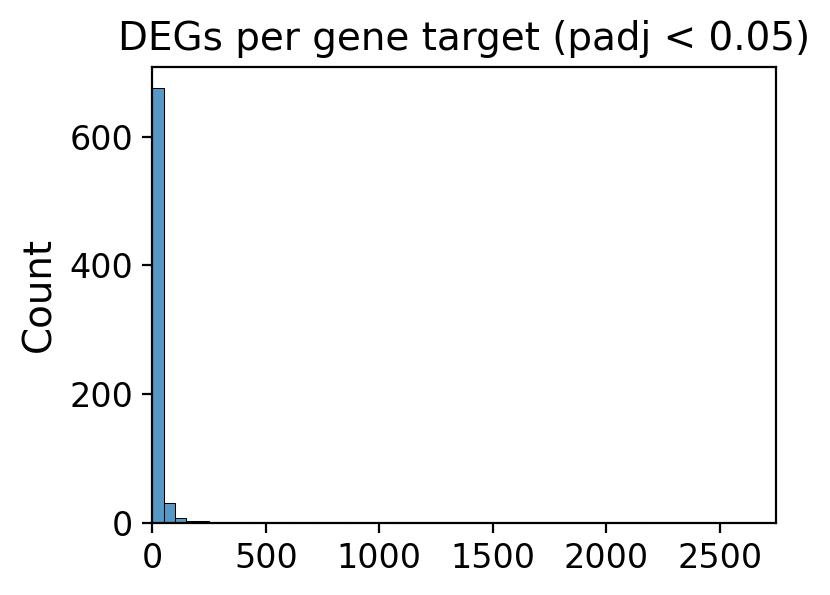

In [47]:
plot_degs_per_kd_histogram(gene_target_n_cells_degs_df5, xmax=2750,
                           title="DEGs per gene target (padj < 0.05)")

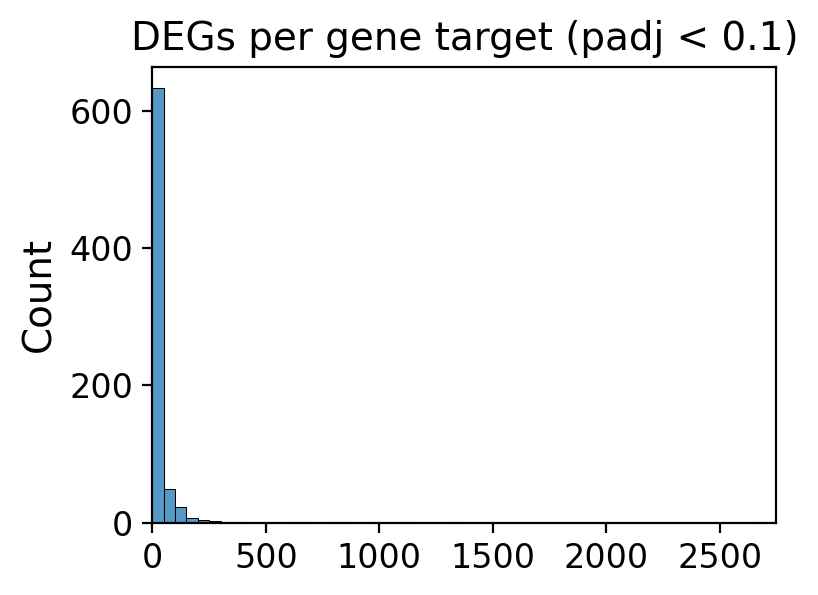

In [48]:
plot_degs_per_kd_histogram(gene_target_n_cells_degs_df10, xmax=2750, 
                           title="DEGs per gene target (padj < 0.1)")

Calculate median and mean DEGs per gene target

In [51]:
def calculate_median_mean_degs_per_gene_target():
    median5 = int(gene_target_n_cells_degs_df5["n_DEGs"].median())
    mean5 = int(gene_target_n_cells_degs_df5["n_DEGs"].mean())
    median10 = int(gene_target_n_cells_degs_df10["n_DEGs"].median())
    mean10 = int(gene_target_n_cells_degs_df10["n_DEGs"].mean())
    print(f"# DEGs per gene target (padj < 0.05): median {median5}, mean {mean5}")
    print(f"# DEGs per gene target (padj < 0.1): median {median10}, mean {mean10}")

In [53]:
calculate_median_mean_degs_per_gene_target()

# DEGs per gene target (padj < 0.05): median 2, mean 20
# DEGs per gene target (padj < 0.1): median 5, mean 30


Compare the 2 padj thresholds by the total number of DEGs for all gene targets

In [8]:
df_list = [gene_target_n_cells_degs_df5, gene_target_n_cells_degs_df10]
df_rows = ["3 chunks, 75 NTC cells per rep, padj < 0.05", 
           "3 chunks, 75 NTC cells per rep, padj < 0.1"]
res_df = \
    build_DE_method_comparison_df(df_list, df_rows, target_type="gene_target")
res_df

,KDs w/ 0 DEGs,>0 DEGs,≥3 DEGs,≥10 DEGs
"3 chunks, 75 NTC cells per rep, padj < 0.05",202,524,352,187
"3 chunks, 75 NTC cells per rep, padj < 0.1",123,603,472,247


In [9]:
def filter_degs_lfc(DE_results_df, lfc_threshold=0.25, padj_threshold=0.05):
    # Get list of perturbations from column labels
    perts = {col.split("_")[0] for col in DE_results_df.columns}
    # Get genes where |L2FC| > threshold and p-adj < threshold
    lfc_degs = set()
    for pert in perts:
        l2fc_col = f"{pert}_log2FoldChange"
        padj_col = f"{pert}_padj"
        lfc_degs.update(DE_results_df.loc[(abs(DE_results_df[l2fc_col]) > lfc_threshold) 
                                   & (DE_results_df[padj_col] < padj_threshold)].index)
    return lfc_degs

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_n_degs_by_lfc_threshold(de_df, padj_threshold=0.05,
                                 lfc_thresholds=[0, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 
                                                 0.6, 0.7, 0.75, 0.8, 0.9, 1],
                                 title="# DEGs"):
    n_degs_list = list()
    for lfc_thr in lfc_thresholds:
        lfc_degs = filter_degs_lfc(de_df, padj_threshold=padj_threshold, 
                                   lfc_threshold=lfc_thr)
        n_degs_list.append(len(lfc_degs))
    lfc_degs_df = pd.DataFrame.from_dict({"lfc": lfc_thresholds, "n_degs": n_degs_list})
    ax = sns.barplot(lfc_degs_df, x="lfc", y="n_degs")
    ax.set_xlabel("|LFC| Threshold")
    ax.set_ylabel("# DEGs")
    ax.set_title(title)
    ax.bar_label(ax.containers[0], fontsize=11)
    ax.grid(False)
    plt.show()

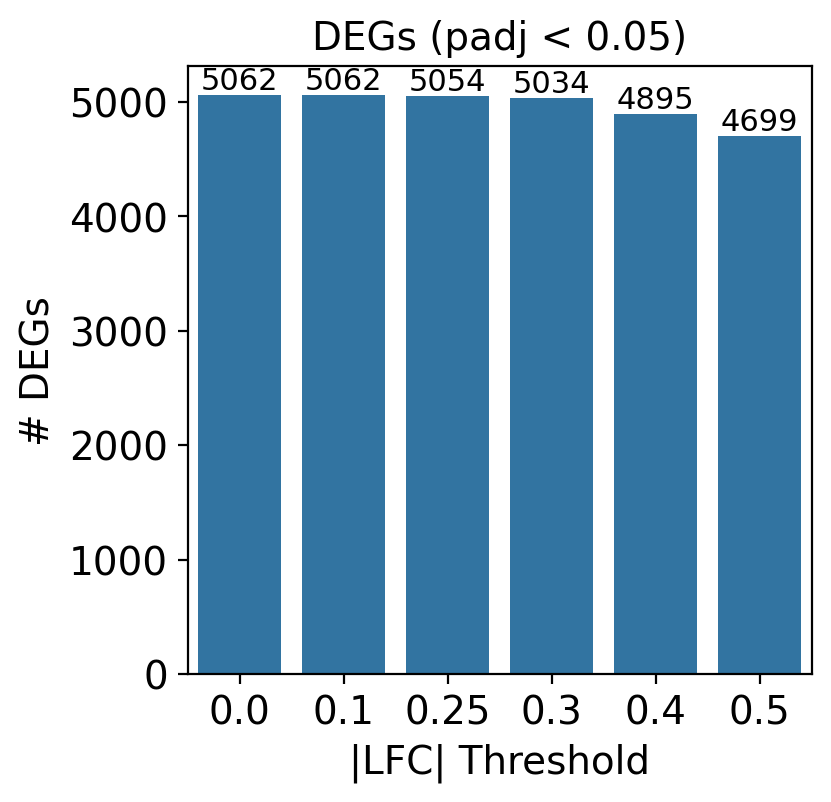

In [11]:
plot_n_degs_by_lfc_threshold(de_results_df_gene_targets, 
                             padj_threshold=0.05,
                             lfc_thresholds=[0, 0.1, 0.25, 0.3, 0.4, 0.5],
                             title="DEGs (padj < 0.05)")

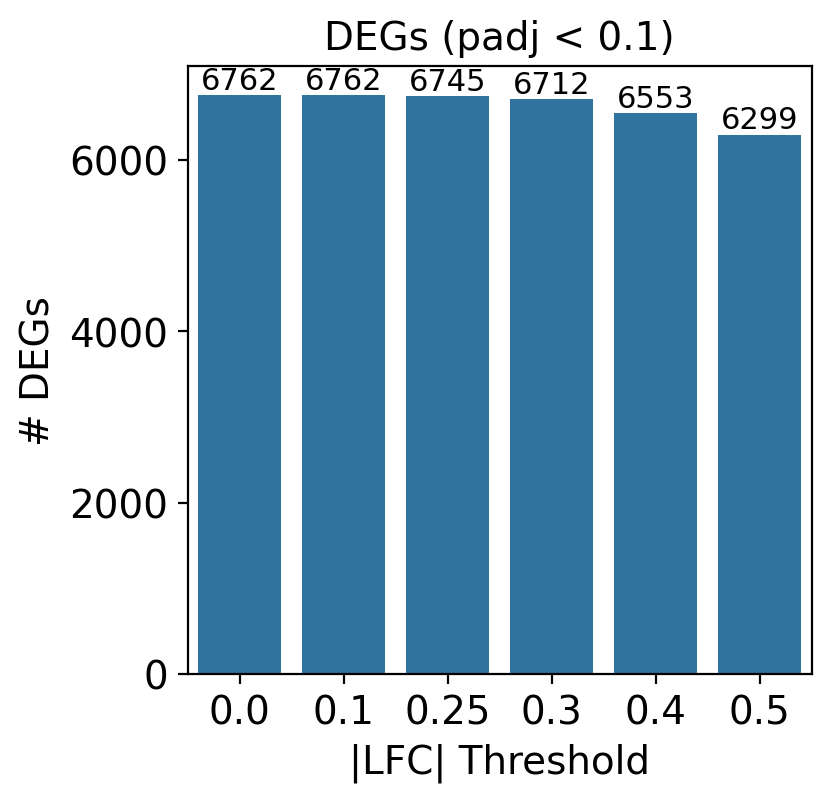

In [12]:
plot_n_degs_by_lfc_threshold(de_results_df_gene_targets, 
                             padj_threshold=0.1,
                             lfc_thresholds=[0, 0.1, 0.25, 0.3, 0.4, 0.5],
                             title="DEGs (padj < 0.1)")

Apply padj and |LFC| thresholds

In [42]:
def filter_adata_degs(adata, DE_results_df, lfc_threshold, padj_threshold):
    degs = filter_degs_lfc(DE_results_df, lfc_threshold, padj_threshold)
    adata_filt = adata[:, adata.var.index.isin(degs)].copy()
    return adata_filt

In [43]:
adata_padj5_lfc0pt25 = filter_adata_degs(adata, de_results_df_gene_targets, 
                                         lfc_threshold=0.25, padj_threshold=0.05)
adata_padj5_lfc0pt25

AnnData object with n_obs × n_vars = 101538 × 5054
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [ ]:
adata_padj10_lfc0pt25 = filter_adata_degs(adata, de_results_df_gene_targets, 
                                         lfc_threshold=0.25, padj_threshold=0.1)

# Pairwise Pearson correlation matrix of mean normalized profiles